In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
from scipy.interpolate import interp1d
import time

nside = 1024
lmax = 1024*3-1

def iqu2teb(IQU, nside, lmax=None):
    print('a')
    alms = hp.map2alm(IQU, lmax=lmax, pol=True)
    print('b')
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=False)

def teb2iqu(TEB, nside, lmax=None):
    alms = hp.map2alm(TEB, lmax=lmax, pol=False)
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=True)

# Begin in Q, U 
### $a_{Q,U} = R \ a_{E,B} + n_{Q,U}$
### $d_{Q,U} = s_{Q,U} + n_{Q,U}$ 
### $\boldsymbol{d} = \boldsymbol{s} + \boldsymbol{n}$


# Algorithm
### $t = T/(T+N) \ d + \bar{N}/(\bar{N} + T) \  s $
### $ s = S/(S+T) \ t $


# Definitions
### $N_{Q,U} = \langle n_{Q,U} n_{Q,U}^\dagger  \rangle $
### $\bar{N} = N - T$
### $ T = \tau \times \mathbf{1}$ , where $\tau = {\rm{min}} \big( N \big)$

# Signal covariance [EE,BB]

In [2]:
s_cov_diag = np.load('s_cov_EE_1024.npy')
s_cov_diag = np.hstack([s_cov_diag, (s_cov_diag*0.) + np.min(s_cov_diag)*1e-10])

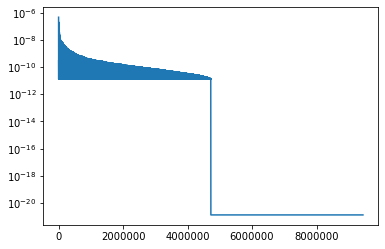

In [3]:
_ = plt.plot(s_cov_diag), plt.yscale('log')

# Data

In [4]:
data_QU = hp.read_map('./map_mock_des1024_QU.fits', field=(0,1))
data_vec = data_QU[0] + 1j* data_QU[1]

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


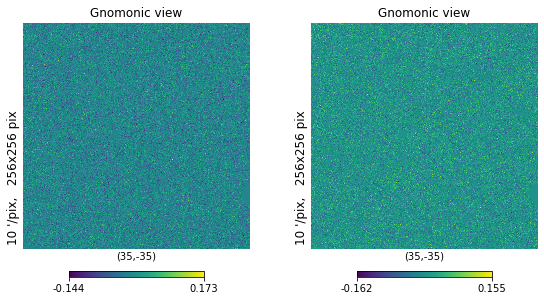

In [5]:
_ = plt.figure(figsize = (12,4)), hp.gnomview(data_vec.real, sub=(1,3,2), reso=10, rot = (35,-35), xsize=256)
_ = hp.gnomview(data_vec.imag, sub=(1,3,3), reso=10, rot = (35,-35), xsize=256)

# Noise covariance $N =  N_{QQ}, N_{UU} $

In [6]:
noise_diag = hp.read_map('map_noise_cov_des1024_QU.fits', field=(0,1))
noise_diag = np.concatenate([noise_diag[0],noise_diag[1]])

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [7]:
noise_diag.shape

(25165824,)

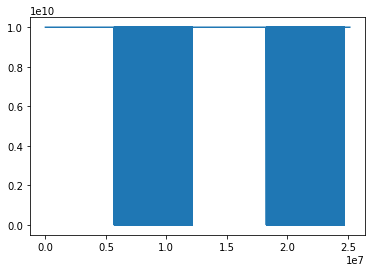

In [8]:
plt.plot(noise_diag[:])

In [9]:
tau = np.min(noise_diag)
print(tau)
T_pixel = np.ones(noise_diag.shape)*tau
noise_bar_diag = noise_diag - tau

0.00017164225573651493


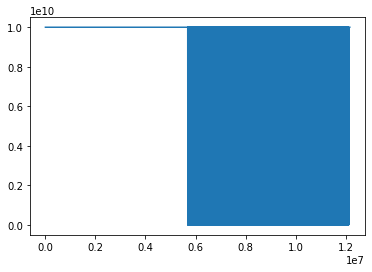

In [10]:
plt.plot(noise_bar_diag[:12165824])

In [11]:
random_T_field = np.random.normal(0., np.sqrt(tau), hp.nside2npix(nside))

In [12]:
power_t_qq = hp.anafast(hp.ud_grade(random_T_field,nside), lmax = nside*3-1)
power_t_pol = hp.anafast([random_T_field*0.,random_T_field,random_T_field],
                          lmax = nside*3-1, pol = True)
tau_ell = np.mean([power_t_pol[1][50:nside*2], power_t_pol[2][50:nside*2], power_t_qq[50:nside*2]]) 

In [13]:
tau_ell

1.7135825948996454e-10

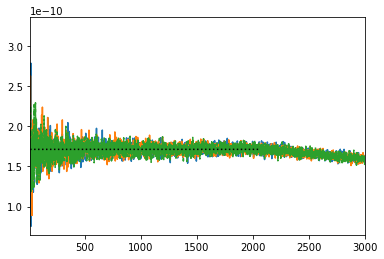

In [14]:
plt.plot(power_t_pol[1])
plt.plot(power_t_pol[2])
plt.plot([tau_ell]*nside*2, ':', c='black')
plt.plot(power_t_qq, '--'), plt.xlim(10,3000)
_ = plt.ylim(np.min(power_t_pol[2][50:nside*2])*0.5,np.max(power_t_pol[2][50:nside*2])*1.5)
plt.plot([tau_ell]*nside*2, ':', c='black')

In [15]:
T_ell = np.ones(s_cov_diag.shape)*tau_ell

# Implementation (if ud_grading up does the tau change?)
Make a field with T_QU covariance, make a copy upgraded to 2048, compare the power spectra of both 

In [16]:
harmonic_operator = s_cov_diag/(s_cov_diag+T_ell)
pixel_operator_signal = (noise_bar_diag/(noise_bar_diag+T_pixel))
pixel_operator_data = (T_pixel / (T_pixel + noise_diag))

In [14]:
n_iter = 20
data_vec_QU = np.concatenate([data_vec.real, data_vec.imag])
s = np.zeros(data_vec_QU.shape, dtype='complex')

convergence_test = [0.]



for i in range(n_iter):
    time_counter = time.time()
    
    t = pixel_operator_data * data_vec_QU + pixel_operator_signal*s # here t = concat[t_Q, t_U]
    t = np.real(t)
    t = [t[int(t.shape[0]/2):]*0.,t[:int(t.shape[0]/2)],t[int(t.shape[0]/2):]] # here t = {t_I = 0, t_Q, t_U}
    t = hp.ud_grade(t, nside) # now upgrade
    
    t_alm = hp.map2alm(t, lmax = 3*(nside)-1, pol=True) 
    
    s = harmonic_operator*np.concatenate([t_alm[1], t_alm[2]])
    s = [s[int(s.shape[0]/2):]*0.,s[:int(s.shape[0]/2)],s[int(s.shape[0]/2):]]
    
    print(np.var(s[0]), np.var(s[1]), np.var(s[2]))
    convergence_test.append(np.var(s[1]))
    

    s = hp.alm2map(s, nside=nside, lmax=nside*3-1, verbose=False, pol=True)
    s_qu = np.copy(s)
    s = np.concatenate([s[1], s[2]])
    print(time.time() -time_counter)

0.0 1.9111897718466393e-13 1.5241710886712824e-34
617.6023898124695
0.0 3.839084077332627e-13 1.519557225076595e-34
598.6817469596863
0.0 5.238975093026627e-13 1.5180932666987767e-34
3384.0624299049377
0.0 6.268692373375155e-13 1.5174241836311763e-34
336.0665092468262
0.0 7.041477508847667e-13 1.5170514865275892e-34
312.6665029525757
0.0 7.630628303346744e-13 1.516819094699029e-34
366.1819610595703
0.0 8.085495873750054e-13 1.5166634308006995e-34
371.4097878932953
0.0 8.440549243345842e-13 1.5165538488438202e-34
414.54992604255676
0.0 8.720486758690123e-13 1.516473819454607e-34
390.37221002578735
0.0 8.94332079380449e-13 1.5164136864761928e-34
380.25282406806946
0.0 9.122357496530057e-13 1.5163674618355387e-34
388.67576575279236
0.0 9.26752578309794e-13 1.5163312554478054e-34
395.82682394981384
0.0 9.386297459382884e-13 1.516302444157519e-34
1340.766842842102
0.0 9.484337885516446e-13 1.5162792041785152e-34
593.4053270816803
0.0 9.56597303200162e-13 1.5162602346952585e-34
540.480900049

([<matplotlib.lines.Line2D at 0x11ba91240>],
 Text(0, 0.5, 'var'),
 Text(0.5, 0, 'n iteration'))

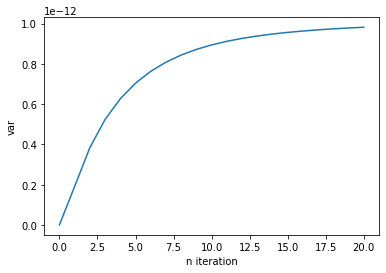

In [15]:
plt.plot(convergence_test), plt.ylabel('var'), plt.xlabel('n iteration')

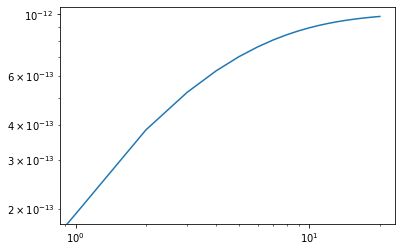

In [16]:
plt.loglog(convergence_test)

In [17]:
s_eb = iqu2teb(s_qu, nside, lmax = nside*3 -1)

a
b
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


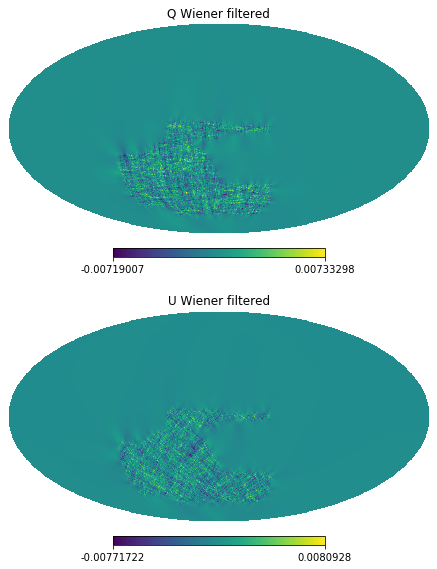

In [18]:
_ = plt.figure(figsize=(6,8))
_ = hp.mollview(s_qu[1], sub=(2,1,1), title='Q Wiener filtered')
_ = hp.mollview(s_qu[2], sub=(2,1,2), title='U Wiener filtered')

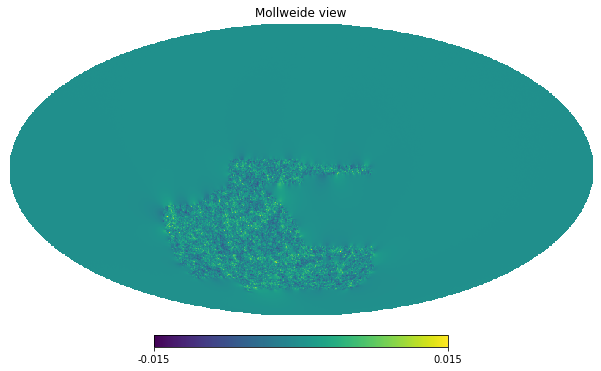

In [19]:
hp.mollview(s_eb[1], min = -0.015, max = 0.015)

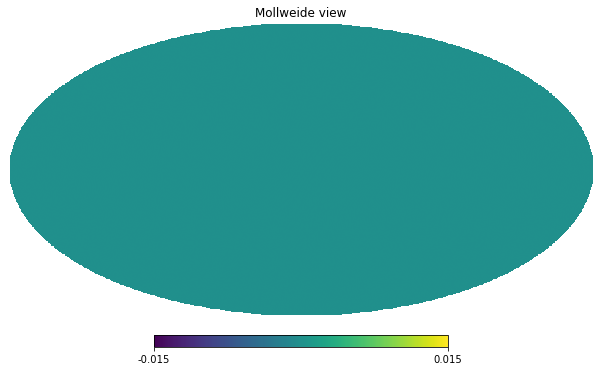

In [20]:
hp.mollview(s_eb[2], min = -0.015, max = 0.015)

In [21]:
np.save('test_wiener_EB_230320', np.array(s_eb[1], dtype = 'float'))

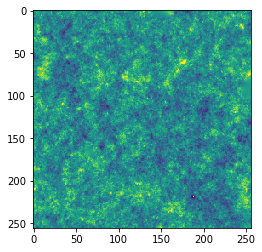

In [30]:
projected_wiener = hp.gnomview(s_eb[1], reso = 8, rot=(30,-40),
                       xsize = 256,return_projected_map=True), plt.close()
projected_wiener = projected_wiener[0]
plt.imshow(projected_wiener.data ,clim=(-0.01, 0.01))
np.save('projected_wienerEB',projected_wiener.data)